---

# 9 Advanced deep learning for computer vision

## 9.1 Three essential computer vision tasks

In [1]:
import os
import sys
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

- *Image classification*: assign one or more labels to an images;
- *Image segmentation*: partition image into different areas (locating categories of bojects), operates on **pixels**;
- *Object detection*: draw rectangles around object.

<!-- ![Chollet three tasks](images/chollet/figure11.1.png) -->

![Chollet three tasks](https://raw.githubusercontent.com/jchwenger/AI/main/5-additional-material/images/chollet/figure11.1.png)

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter11_image-segmentation/#computer-vision-tasks), Chapter 11, figure 11.1</small>


---

## 9.2 An image segmentation example

[Oxford pets reference page](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [2]:
REPO_DIR = pathlib.Path("oxford-pets")
if not os.path.exists(REPO_DIR):
    !git clone https://github.com/ml4py/dataset-iiit-pet oxford-pets/dataset-iiit-pet

Cloning into 'oxford-pets/dataset-iiit-pet'...
remote: Enumerating objects: 18465, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 18465 (delta 1), reused 3 (delta 1), pack-reused 18460 (from 1)
Receiving objects: 100% (18465/18465), 772.55 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (3678/3678), done.
Updating files: 100% (18477/18477), done.


In [3]:
!ls oxford-pets

dataset-iiit-pet


In [8]:
BATCH_SIZE = 64
IMG_SIZE = (200, 200)

BASE_DIR = REPO_DIR / "dataset-iiit-pet"
INPUT_DIR = BASE_DIR / "images/"
TARGET_DIR = BASE_DIR / "annotations/trimaps/"

In [9]:
INPUT_IMG_PATHS = sorted(
    [
        str(path) for path in INPUT_DIR.glob("*.jpg")
    ]
)

TARGET_PATHS = sorted(
    [
        str(path)
        for path in TARGET_DIR.glob("*.png")
        if not path.name.startswith(".")
    ]
)

image shape: (500, 448)


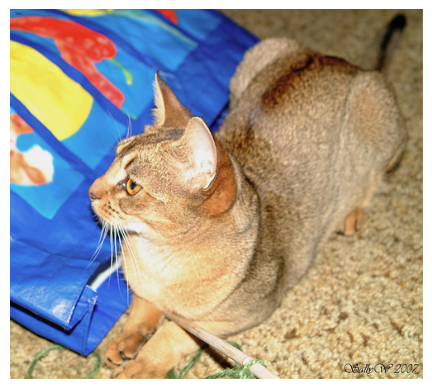

In [10]:
plt.axis("off")
img = tf.keras.utils.load_img(INPUT_IMG_PATHS[9])
plt.imshow(tf.keras.utils.load_img(INPUT_IMG_PATHS[9]))
print(f"image shape: {img.size}")

array shape: (448, 500, 1)
values: [127 254   0]


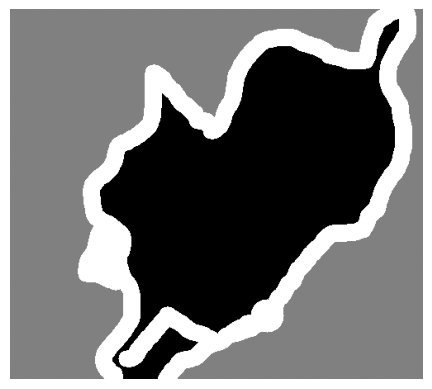

In [11]:
def display_target(target_array):
    print(f"array shape: {target_array.shape}")
    normalized_array = (target_array.astype("uint8") - 1) * 127
    values = tf.unique(tf.reshape(normalized_array, (-1)))

    # background is 127 (grey), boundary is 256 (white), object 0 (black)
    print(f"values: {values.y.numpy()}")
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0], cmap="gray")

# "grayscale" mode yields a (W, H, 1) image – without it it would be (W, H, 3)
img = tf.keras.utils.img_to_array(tf.keras.utils.load_img(TARGET_PATHS[9], color_mode="grayscale"))
display_target(img)

In [12]:
input_fname_ds = tf.data.Dataset.list_files(f"{INPUT_DIR}/*.jpg", shuffle=False)
target_fname_ds = tf.data.Dataset.list_files(f"{TARGET_DIR}/*.png", shuffle=False).filter(
    lambda x : not tf.strings.regex_full_match(x, ".*/\\..*")) # remove files starting with .

main_fname_ds = tf.data.Dataset.zip(
    (input_fname_ds, target_fname_ds)
)

In [13]:
# sanity check, all file names are equal to their targets
sanity = True
if not sanity:
    for f,g in main_fname_ds:
        fstr = f.numpy().decode()
        gstr = g.numpy().decode()
        fs = fstr[fstr.rfind("/"):-3]
        gs = gstr[gstr.rfind("/"):-3]
        if fs != gs:
            print(fs)
            print(gs)

In [14]:
def parse_image(fname):
    """Source: https://www.tensorflow.org/guide/data#decoding_image_data_and_resizing_it"""
    img = tf.io.read_file(fname)
    img = tf.io.decode_jpeg(
        img, channels=3, try_recover_truncated = True,
        acceptable_fraction=1,
    )
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img

def parse_target(fname):
    img = tf.io.read_file(fname)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.resize(img, IMG_SIZE)
    return img - 1

def map_func(x, y):
    return parse_image(x), parse_target(y) # , x, y

processed_ds = main_fname_ds.map(map_func)

In [15]:
# check image and mask
sanity = True
if not sanity:
    for i,t in processed_ds.skip(10):
        print(i.shape)
        print(t.shape)
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(i)
        ax[1].imshow(t * 127)
        break

In [16]:
# shuffle before you batch https://stackoverflow.com/a/50453698
# prefetch: https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options
# complete tutorial: https://www.tensorflow.org/guide/data_performance
# also: https://cs230.stanford.edu/blog/datapipeline/#best-practices
val_steps = 16

                           # ↓ from 1024 onward
train_dataset = processed_ds.skip(BATCH_SIZE * val_steps)\
                    .shuffle(BATCH_SIZE * val_steps)\
                    .batch(BATCH_SIZE, drop_remainder=True)\
                    .prefetch(tf.data.AUTOTUNE)\
                    .repeat()

                         # ↓ the first 1024
val_dataset = processed_ds.take(BATCH_SIZE * val_steps)\
                    .shuffle(BATCH_SIZE * val_steps)\
                    .batch(BATCH_SIZE, drop_remainder=True)\
                    .prefetch(tf.data.AUTOTUNE)\
                    .repeat()

In [17]:
sanity = True
ds = train_dataset # val_dataset
if not sanity:
    for i,t in ds.skip(6):
        print(i.shape)
        print(t.shape)

        fig, ax = plt.subplots(1,2)
        ax[0].imshow(i[0].numpy())
        normalized_array = t[0] * 127
        ax[1].imshow(normalized_array[:, :, 0])
        break

## Model

In [19]:
                                   # ↓ backward compatibility with Chollet's code down below
def get_model(img_size, num_classes, tf_dataset=True):
    inputs = tf.keras.Input(shape=img_size + (3,))
    if not tf_dataset:                        # in Chollet's original setup the rescaling happens here, whereas
        x = tf.keras.tf.keras.layers.Rescaling(1./255)(inputs)  # tf.image.convert_image_dtype does that for us in the pipeline
    else:
        x = inputs

    # shrink input (like an encoder)
    x = tf.keras.layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # unshrink input (like a decoder)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = get_model(img_size=IMG_SIZE, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

### Reminder: Transposed Convolutions

<!-- ![Kaveh, stack overflow](images/deconv/deconv.1.png) -->
![Kaveh, stack overflow](https://raw.githubusercontent.com/jchwenger/AI/main/5-additional-material/images/deconv/deconv.1.png)

<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

<!-- ![Kaveh, stack overflow](images/deconv/deconv.2.png) -->
![Kaveh, stack overflow](https://raw.githubusercontent.com/jchwenger/AI/main/5-additional-material/images/deconv/deconv.2.png)


<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

## Compilation & Training

In [21]:
foreground_iou = tf.keras.metrics.IoU(
    # Specifies the total number of classes
    num_classes=3,
    # Specifies the class to compute IoU for (0 = foreground)
    target_class_ids=(0,),
    name="foreground_iou",
    # Our targets are sparse (integer class IDs).
    sparse_y_true=True,
    # But our model's predictions are a dense softmax!
    sparse_y_pred=False,
)

In [22]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=[foreground_iou],
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(BASE_DIR, "oxford_segmentation.keras"),
        save_best_only=True
    )
]

# to revert back to Chollet's version, follow the comments
history = model.fit(
    train_dataset, # Chollet: train_input_imgs, train_targets,
    epochs=50,
    # Not in Chollet! (our tf.dataset is infinite, we must give the number of steps)
    steps_per_epoch=(len(INPUT_IMG_PATHS) - BATCH_SIZE * 16) // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    #  Chollet: validation_data=(val_input_imgs, val_targets)
    validation_data=val_dataset,
    # Not in Chollet (infinite tf.dataset, we provide the steps ourselves)
    validation_steps=val_steps,
    callbacks=callbacks,
)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - foreground_iou: 0.5033 - loss: 0.6979 - val_foreground_iou: 0.4788 - val_loss: 0.7035
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - foreground_iou: 0.5214 - loss: 0.6627 - val_foreground_iou: 0.5563 - val_loss: 0.6247
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - foreground_iou: 0.5314 - loss: 0.6486 - val_foreground_iou: 0.5490 - val_loss: 0.6295
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - foreground_iou: 0.5412 - loss: 0.6266 - val_foreground_iou: 0.3068 - val_loss: 0.7959
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - foreground_iou: 0.5373 - loss: 0.6237 - val_foreground_iou: 0.5815 - val_loss: 0.5801
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - foreground_iou: 0.5637 - loss: 0.5938 - val_foreground_iou: 0.5732 - val_loss: 0.5705
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - foreground_iou: 0.5581 - loss: 0.5958 - val_foreground_iou: 0.5457 - val_loss: 0.5832
Epoch 8/50
99/99 ━━━━━━

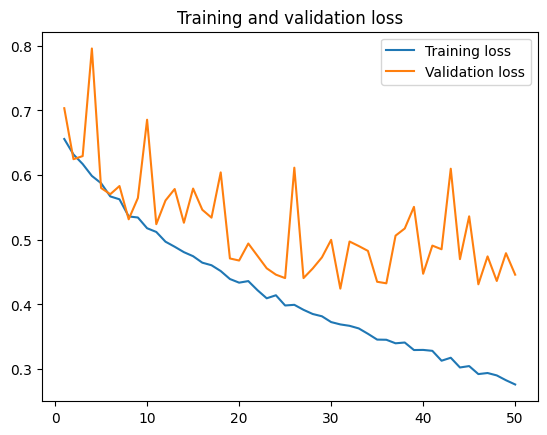

In [23]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [32]:
def display_mask(model, i):

    # get image
    # change to this line in Chollet's original setup
    # test_image = val_input_imgs[i]
    for img, tgt in val_dataset.skip(i).take(1):
        test_image = img[0]

    # get mask
    pred = model.predict(np.expand_dims(test_image, 0), verbose=0)[0]
    mask = np.argmax(pred, axis=-1)
    mask *= 127

    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.axis("off")
    ax1.imshow(tf.keras.utils.array_to_img(test_image))
    ax2.axis("off")
    ax2.imshow(mask, cmap="gray")
    plt.show()

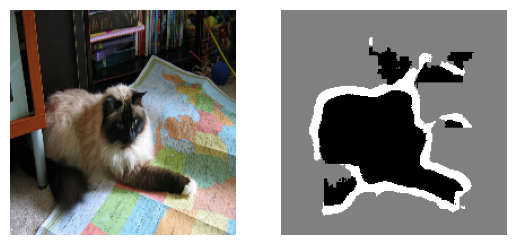

In [33]:
i = 10
display_mask(model, i)

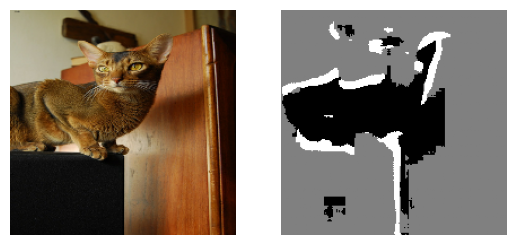

In [34]:
i = 1
display_mask(model, i)

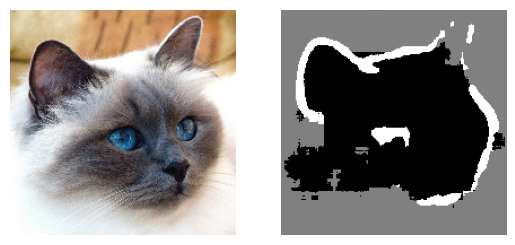

In [35]:
i = 4
display_mask(model, i)

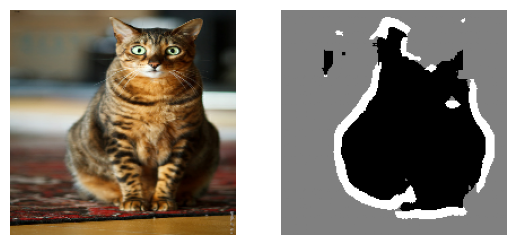

In [36]:
reloaded_model = tf.keras.models.load_model(os.path.join(BASE_DIR, "oxford_segmentation.keras"))
i = 4
display_mask(reloaded_model, i)

### Using a pretrained segmentation model

#### Downloading the Segment Anything Model

In [37]:
import keras_hub

model = keras_hub.models.ImageSegmenter.from_preset("sam_huge_sa1b")

100%|██████████| 3.06k/3.06k [00:00<00:00, 6.11MB/s]


100%|██████████| 5.77k/5.77k [00:00<00:00, 11.9MB/s]


100%|██████████| 2.39G/2.39G [02:41<00:00, 15.8MB/s]


100%|██████████| 2.39G/2.39G [02:36<00:00, 16.3MB/s]


In [38]:
model.count_params()

641090864

#### How Segment Anything works

![An example image from the SA-1B dataset](images/chollet/figure11.7.jpg)

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter11_image-segmentation/#how-segment-anything-works), Chapter 11, figure 11.7</small>

![The Segment Anything high-level architecture overview](images/chollet/figure11.8.png)

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter11_image-segmentation/#how-segment-anything-works), Chapter 11, figure 11.8</small>

#### Preparing a test image

259153/259153 ━━━━━━━━━━━━━━━━━━━━ 1s 3us/step


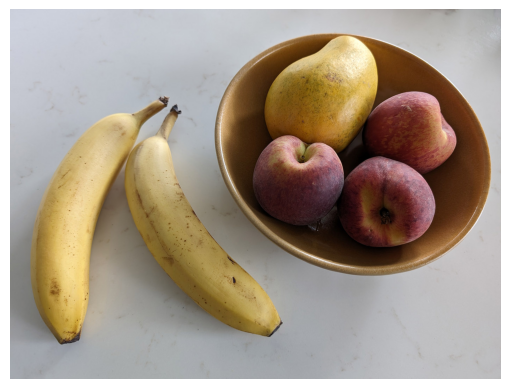

In [39]:
path = tf.keras.utils.get_file(
    origin="https://s3.amazonaws.com/keras.io/img/book/fruits.jpg"
)
pil_image = tf.keras.utils.load_img(path)
image_array = tf.keras.utils.img_to_array(pil_image)

plt.imshow(image_array.astype("uint8"))
plt.axis("off")
plt.show()

In [41]:
# from keras import ops

image_size = (1024, 1024)

def resize_and_pad(x):
    return tf.keras.ops.image.resize(x, image_size, pad_to_aspect_ratio=True)

image = resize_and_pad(image_array)

In [46]:
def show_image(image, ax):
    ax.imshow(image.numpy().astype("uint8"))

def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w, _ = mask.shape
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(points, ax):
    x, y = points[:, 0], points[:, 1]
    ax.scatter(x, y, c="green", marker="*", s=375, ec="white", lw=1.25)

def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, ec="red", fc="none", lw=2))

#### Prompting the model with a target point

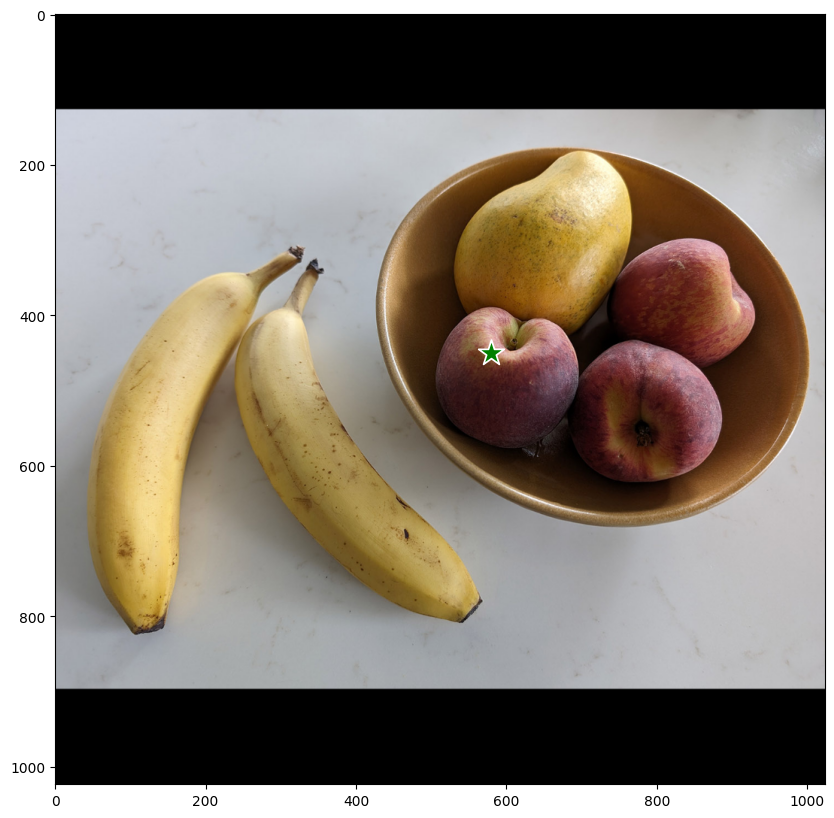

In [47]:
input_point = np.array([[580, 450]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_points(input_point, plt.gca())
plt.show()

In [48]:
outputs = model.predict(
    {
        "images": tf.expand_dims(image, axis=0),
        "points": tf.expand_dims(input_point, axis=0),
        "labels": tf.expand_dims(input_label, axis=0),
    }
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step


In [49]:
outputs["masks"].shape

(1, 4, 256, 256)

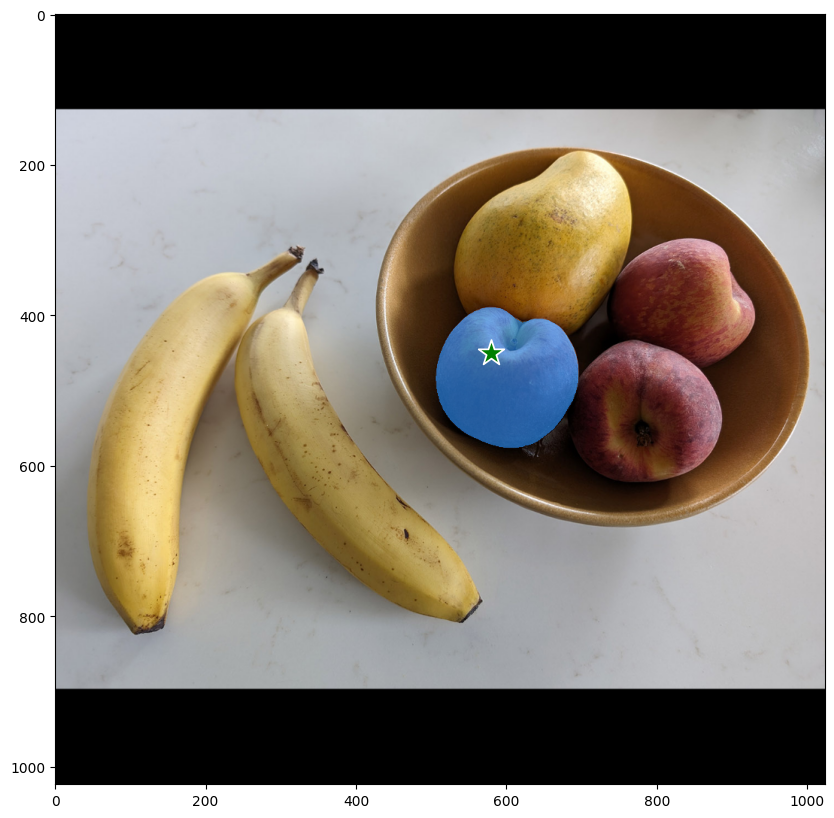

In [50]:
def get_mask(sam_outputs, index=0):
    mask = sam_outputs["masks"][0][index]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize_and_pad(mask)
    return mask.numpy() > 0.0

mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


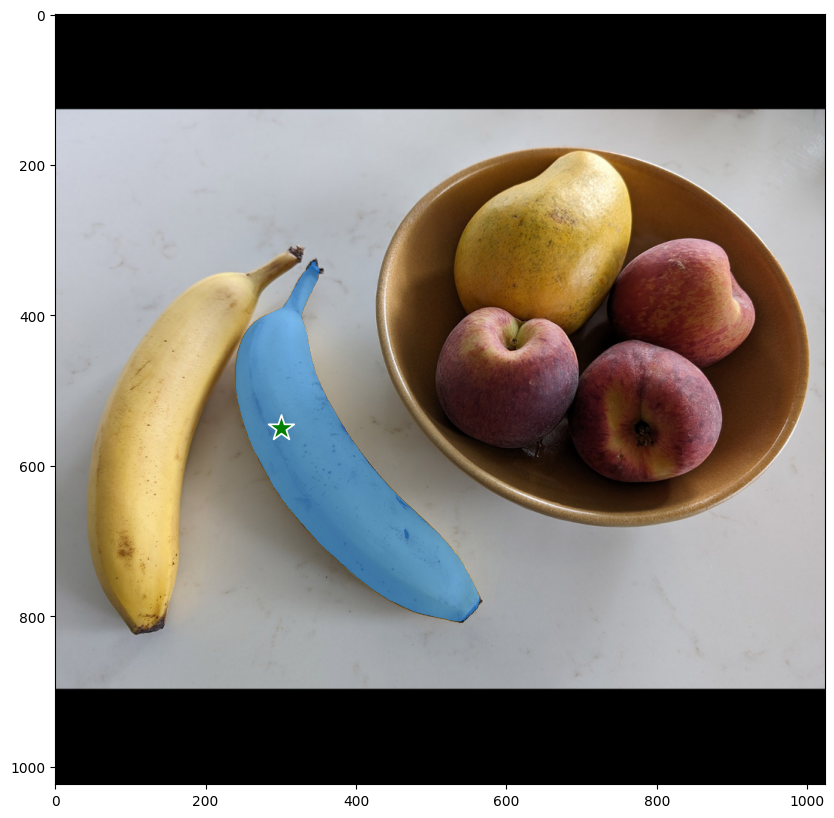

In [51]:
input_point = np.array([[300, 550]])
input_label = np.array([1])

outputs = model.predict(
    {
        "images": tf.expand_dims(image, axis=0),
        "points": tf.expand_dims(input_point, axis=0),
        "labels": tf.expand_dims(input_label, axis=0),
    }
)
mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.show()

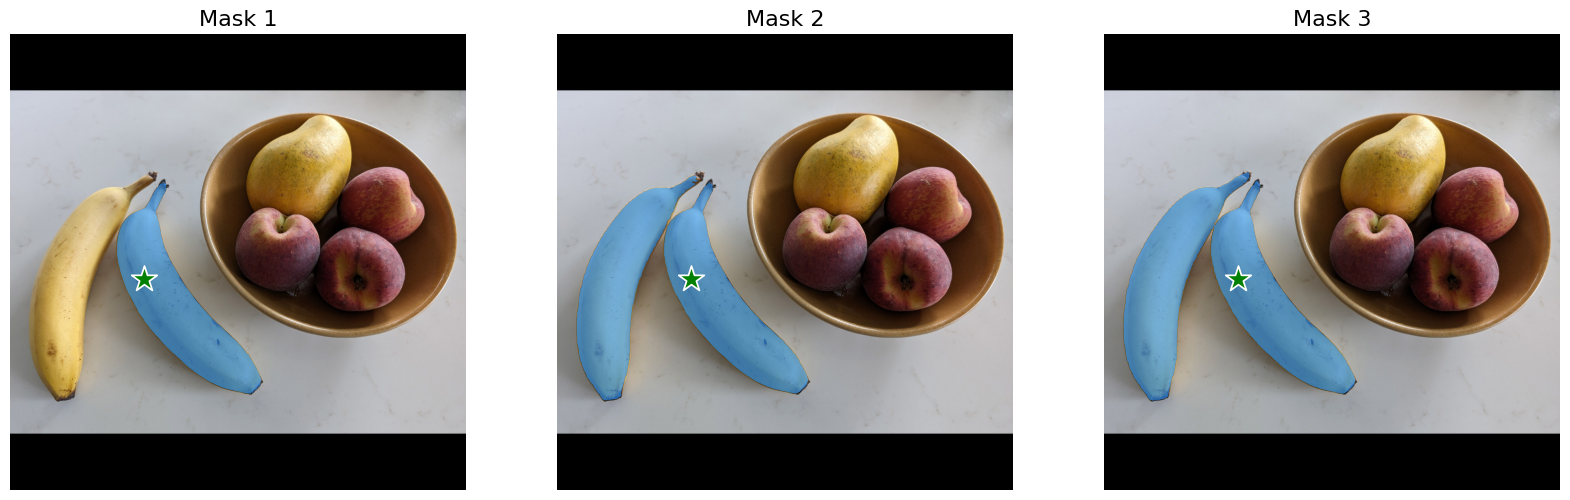

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(20, 60))
masks = outputs["masks"][0][1:]
for i, mask in enumerate(masks):
    show_image(image, axes[i])
    show_points(input_point, axes[i])
    mask = get_mask(outputs, index=i + 1)
    show_mask(mask, axes[i])
    axes[i].set_title(f"Mask {i + 1}", fontsize=16)
    axes[i].axis("off")
plt.show()

#### Prompting the model with a target box

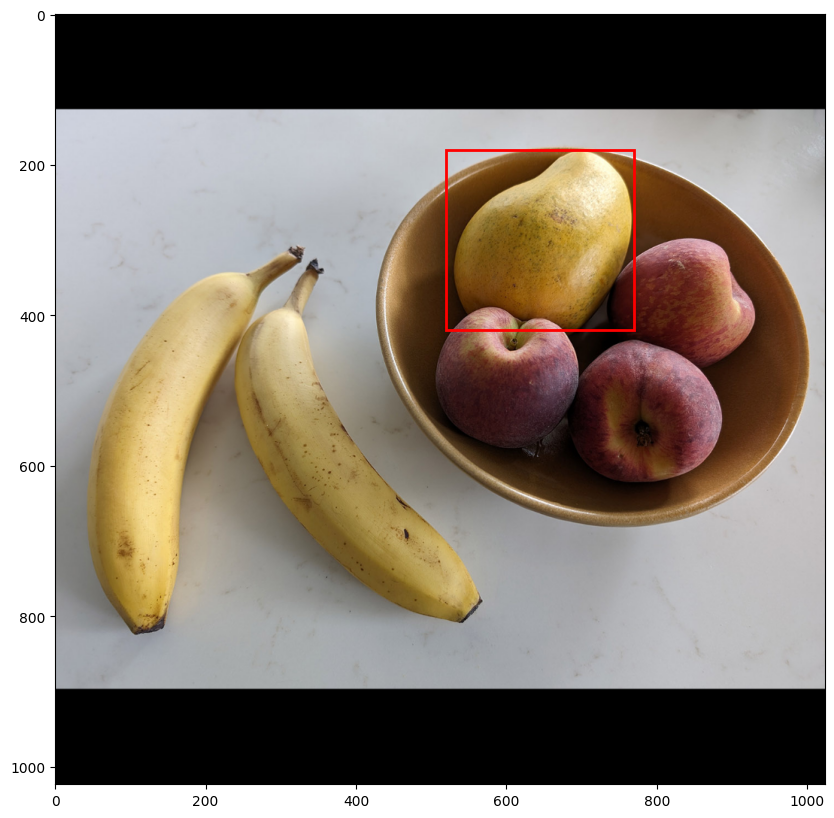

In [53]:
input_box = np.array(
    [
        [520, 180],
        [770, 420],
    ]
)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_box(input_box, plt.gca())
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


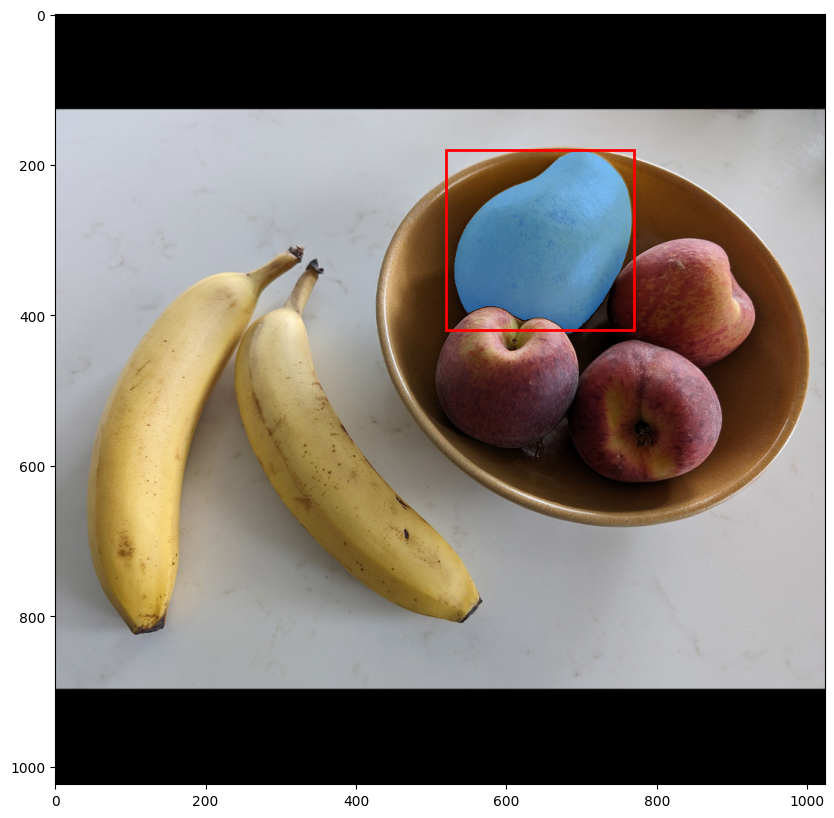

In [61]:
outputs = model.predict(
    {
        "images": tf.expand_dims(image, axis=0),
        "boxes": tf.reshape(input_box, shape=(1,1, *input_box.shape)),
    }
)
mask = get_mask(outputs, 0)
plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.show()

## See also

[Keras tutorial on Segment Anything](https://keras.io/keras_hub/guides/segment_anything_in_keras_hub/)

["Automatically generating object masks with SAM" notebook (Keras)](https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/Segment_Anything_Automatic_Mask_Generator_Demo.ipynb)

[Facebook Research's "Segment Anything"](https://github.com/facebookresearch/segment-anything) and ["Segment Anything 2"](https://github.com/facebookresearch/sam2) GitHub repositories